# DATA 620
### Assignment 6 - Document Classification
### Steven Ellingson

I've decided to return again to my movie dataset for this assignment.  I will be bringing in movie scripts though from www.imsdb.com.  I will attempt to classify a script into genres based on the script. Because movies have many genres, I will be just be predicting whether a specific genre shows up in the list. This could be expanded for all genres, but I'll just stick to two for this assignment.

The movie data comes from here:  https://www.kaggle.com/rounakbanik/the-movies-dataset

In a previous project I loaded this into a database, and will be pulling it from there.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector as dbc
import re
import warnings
import os

import requests
import urllib.request
import time
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import pickle

import nltk

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

seed = 4312
from xgboost import plot_importance
from matplotlib import pyplot as plt
import networkx as nx
import networkx.algorithms.bipartite as bipartite
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')
db = dbc.connect(
    database='movies',
    host='127.0.0.1',
    user='root',
    passwd='XXXXXXX'
)

I will start by pulling my movie/genre list. I will pull any movie that I think has a chance of being on this list - this should only be English-speaking feature-films.  I'm pulling some extra info for the ones that come up with more than one result.

In [2]:
SQL = """
select 
m.id,
m.title,
m.release_date,
m.tagline,
group_concat(distinct g.name order by g.name) as genre_list,
m.vote_count,
m.budget,
group_concat(distinct case when mc.job like '%writer%' or mc.job like '%screenplay%' then c.name end) as writers
from movies m 
left join movie_genres mg on m.id= mg.movie_id
left join genres g on mg.genre_id = g.id
left join movie_crew mc on m.id = mc.movie_id
left join crew c on mc.crew_id = c.id
where original_language = 'en'
	and vote_count >= 10
	and status = 'Released'
	and runtime >= 60
group by m.id
"""

movies = pd.read_sql(SQL,db)
movies.set_index('id',inplace=True, drop=False)
movies.head(10)

,id,title,release_date,tagline,genre_list,vote_count,budget,writers
id,,,,,,,,
5,5,Four Rooms,1995-12-09,Twelve outrageous guests. Four scandalous requ...,"Comedy,Crime",539,4000000.0,"Alexandre Rockwell,Allison Anders,Quentin Tara..."
6,6,Judgment Night,1993-10-15,Don't move. Don't whisper. Don't even breathe.,"Action,Crime,Thriller",79,0.0,Lewis Colick
11,11,Star Wars,1977-05-25,"A long time ago in a galaxy far, far away...","Action,Adventure,Science Fiction",6778,11000000.0,George Lucas
12,12,Finding Nemo,2003-05-30,There are 3.7 trillion fish in the ocean. They...,"Animation,Family",6292,94000000.0,"Andrew Stanton,Bob Peterson,David Reynolds"
13,13,Forrest Gump,1994-07-06,"The world will never be the same, once you've ...","Comedy,Drama,Romance",8147,55000000.0,Eric Roth
14,14,American Beauty,1999-09-15,Look closer.,Drama,3438,15000000.0,Alan Ball
15,15,Citizen Kane,1941-04-30,It's Terrific!,"Drama,Mystery",1244,839727.0,"Herman J. Mankiewicz,John Houseman,Mollie Kent..."
16,16,Dancer in the Dark,2000-05-17,You don't need eyes to see.,"Crime,Drama,Music",392,12800000.0,Lars von Trier
17,17,The Dark,2006-01-26,One of the living for one of the dead.,"Horror,Mystery,Thriller",76,0.0,Stephen Massicotte


OK, now I will get the list of scripts from imsdb. They are all listed on one page, so I can scrape that and turn it into a data frame.


In [3]:
url = 'https://www.imsdb.com/all%20scripts/'
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

Luckily the titles are all in a list using the "p" tag. I can loop though those and get every title and the hyperlink to the script.

In [4]:
scripts = pd.DataFrame([[x.contents[0].contents[0],x.contents[0]['href'], x.contents[1], x.contents[3].contents[0].replace('Written by ','')] for x in soup.findAll('p')], columns = ['title', 'link','script_date', 'writers'])

Glancing through this list, I noticed right away that the "The" movies put the "The" at the end after the comma. Let's take a quick look and see how many of those there are and if there are other things after the comma.

In [5]:
parsed = scripts.title.str.split(pat=',',expand = True)

In [6]:
parsed[[0,2]].groupby(2).count()

,0
2,
Love,1


Just one movie has a second comma, but it's an actual Oxford comma in the title: Crazy, Stupid, Love.

In [7]:
parsed[[0,1]].groupby(1).count().sort_values(0, ascending=False)

,0
1,
The,212
A,5
An,1
El,1
Hidden Dragon,1
L' (The Adventure),1
Lies and Videotape,1
New York,1
Rest & Motion,1


OK, so It's really just A and The.  Also need to watch out for (), which could be a Year or something else that helps identify the movie.
Let's create a new field that moves the A and the to the beginning, strips out non-alphanumeric characters, and changes to lower case.
I'll create a function for this so we can do the same with the movies dataframe. Then I'll pull some changes to see how they look.

In [8]:
def clean_series(s):
    s = s.str.split('(').str[0].str.strip()
    s = s.str.replace(r'^(.+), (A|The)$',r'\2 \1',regex=True)
    s = s.str.replace(r'[^a-zA-Z\d ]','',regex=True)
    return(s.str.lower())

scripts['title_clean'] = clean_series(scripts['title'])
movies['title_clean'] = clean_series(movies['title'])
    
scripts[scripts['title']!=scripts['title_clean']].sort_values('title_clean').head(10)

,title,link,script_date,writers,title_clean
0,10 Things I Hate About You,/Movie Scripts/10 Things I Hate About You Scri...,(1997-11 Draft),"Karen McCullah Lutz,Kirsten Smith,William Shak...",10 things i hate about you
2,12 and Holding,/Movie Scripts/12 and Holding Script.html,(2004-04 Draft),Anthony Cipriano,12 and holding
3,12 Monkeys,/Movie Scripts/12 Monkeys Script.html,(1994-06 Draft),"David Peoples,Janet Peoples",12 monkeys
4,12 Years a Slave,/Movie Scripts/12 Years a Slave Script.html,(Undated Draft),John Ridley,12 years a slave
5,127 Hours,/Movie Scripts/127 Hours Script.html,(Undated Draft),"Simon Beaufoy,Danny Boyle",127 hours
6,1492: Conquest of Paradise,/Movie Scripts/1492: Conquest of Paradise Scri...,(1991-09 Draft),Roslyne Bosch,1492 conquest of paradise
7,15 Minutes,/Movie Scripts/15 Minutes Script.html,(Undated Draft),John Hertzfield,15 minutes
8,17 Again,/Movie Scripts/17 Again Script.html,(2007-10 Draft),Jason Filardi,17 again
10,2001: A Space Odyssey,/Movie Scripts/2001: A Space Odyssey Script.html,(1989-02 Draft),"Stanley Kubrick,Arhur C. Clarke",2001 a space odyssey
12,25th Hour,/Movie Scripts/25th Hour Script.html,(2001-04 Draft),David Benioff,25th hour


In [9]:
scripts[scripts['title']!=scripts['title_clean']].sort_values('title_clean').tail(10)

,title,link,script_date,writers,title_clean
1200,X-Men Origins: Wolverine,/Movie Scripts/X-Men Origins: Wolverine Script...,(Undated Draft),"David Benioff,Skip Woods",xmen origins wolverine
1201,xXx,/Movie Scripts/xXx Script.html,(2001-08 Draft),Rich Wilkes,xxx
1202,Year One,/Movie Scripts/Year One Script.html,(2007-10 Draft),"Harold Ramis,Gene Stupnitsky,Lee Eisenberg",year one
1203,Yes Man,/Movie Scripts/Yes Man Script.html,(2007-02 First draft),"Nicholas Stoller,Danny Wallace",yes man
1204,You Can Count On Me,/Movie Scripts/You Can Count On Me Script.html,(Undated Shooting draft),Kenneth Lonergan,you can count on me
1206,Youth in Revolt,/Movie Scripts/Youth in Revolt Script.html,(2007-07 Draft),Gustin Nash,youth in revolt
1205,You've Got Mail,/Movie Scripts/You've Got Mail Script.html,(1998-02 Draft),"Nora Ephron,Delia Ephron",youve got mail
1207,Zero Dark Thirty,/Movie Scripts/Zero Dark Thirty Script.html,(2011-10 Draft),Mark Boal,zero dark thirty
1208,Zerophilia,/Movie Scripts/Zerophilia Script.html,(2004-03 Draft),Martin Curland,zerophilia
1209,Zootopia,/Movie Scripts/Zootopia Script.html,(Undated Draft),"Jared Bush,Phil Johnston",zootopia


OK, so we'll start by matching up the easy ones, and then see what's left if over:
    

In [10]:
#Initialize a few things
mismatches = None
missing = None
scripts['movie_id']=np.nan

mismatch_count = 0
missing_count = 0
found_count = 0
temp_count = 0
#Loop through and match them up!
for key,row in scripts.iterrows():
    matches = movies[movies.title_clean==row['title_clean']]
    matches['fuzz'] = 0
    matches['script_id'] = key
    matches['script_title'] = row['title']
    matches['script_date'] = row['script_date']
    matches['script_writers'] = row['writers']
    
    if(len(matches)==1):
        found_count = found_count + 1
        scripts.loc[key, 'movie_id'] = matches.index[0]
    else:
        if(len(matches)==0):
            missing_count = missing_count+1
            #Try a fuzzy match. Copy the whole movies dataframe, check the fuzzy match and sort.
            temp_df = movies.copy()
            
            temp_df['fuzz'] = temp_df['title_clean'].apply(lambda x: fuzz.ratio(x, row['title_clean']))
            
            matches = temp_df.sort_values('fuzz', ascending=False).head(3)
            matches['script_id'] = key
            matches['script_title'] = row['title']
            matches['script_date'] = row['script_date']
            matches['script_writers'] = row['writers']
            
            if(missing is None):
                missing = pd.DataFrame(row).T
            else:
                missing = missing.append(row)
        else:
            mismatch_count = mismatch_count+1
                
        if(mismatches is None):
            mismatches = matches.copy()
        else:
            mismatches = mismatches.append(matches, ignore_index=True)

    temp_count=temp_count + 1
    if (temp_count >=100):
        temp_count=0
        print (str(found_count) + ' found, ' + str(missing_count) + ' missing, ' + str(mismatch_count) + ' mismatched.')
        
                
#Write the errors to a csv to manually check out:
mismatches.to_csv('mismatches.csv')
missing.to_csv('missing.csv')
print (str(found_count) + ' found, ' + str(missing_count) + ' missing, ' + str(mismatch_count) + ' mismatched.')

74 found, 20 missing, 6 mismatched.
150 found, 35 missing, 15 mismatched.
233 found, 45 missing, 22 mismatched.
316 found, 56 missing, 28 mismatched.
394 found, 62 missing, 44 mismatched.
479 found, 71 missing, 50 mismatched.
560 found, 83 missing, 57 mismatched.
645 found, 91 missing, 64 mismatched.
720 found, 106 missing, 74 mismatched.
799 found, 117 missing, 84 mismatched.
878 found, 135 missing, 87 mismatched.
955 found, 146 missing, 99 mismatched.
964 found, 147 missing, 99 mismatched.


Alright, so there are 147 movies with no matches, and 99 with multiple matches.  I pushed the data into a csv and manually created the below dictionary to fix them. I was able to match up 162 out of 246.

In [11]:
print("Missing Movies Before:" + str(sum(pd.isnull(scripts['movie_id']))))
script_fix = {2:18164,37:11379,44:2665,47:348,48:8077,50:395,55:25430,58:12142,72:68895,75:814,82:9444,85:96724,94:24913,103:49012,107:18355,110:816,111:817,115:9320,116:24428,123:165,126:9737,140:268,142:415,153:321612,161:39437,184:11622,186:96936,196:619,198:9586,202:22821,205:9303,207:2501,223:9208,234:9894,237:7340,261:411,282:37430,295:884,301:263341,307:11386,321:923,322:8408,324:828,329:34803,332:13018,343:1813,359:64690,370:11374,391:765,399:754,400:38363,402:9738,419:3604,424:9093,435:4488,437:58151,438:11797,441:44363,442:109445,445:5503,448:228150,459:1485,464:5916,470:620,471:2978,475:9504,477:238,478:240,481:929,495:64682,500:9434,517:11282,523:671,524:11618,531:11088,534:11253,536:11569,547:9792,571:43947,584:87,596:23378,602:1635,613:38684,637:393,637:24,640:254,654:5516,669:11976,672:82695,676:14372,678:6522,700:120,701:122,702:121,709:14736,719:9313,720:9509,723:574,725:14462,737:854,745:19403,758:9822,787:564,811:377,812:10131,826:161,829:2623,830:11234,845:274870,847:2024,864:285,867:871,871:1089,872:36897,881:38321,884:30197,885:18133,886:36599,890:539,902:1369,905:567,918:281957,926:5548,931:454,938:96721,944:10003,945:11468,946:11528,951:111,960:116745,962:4584,977:10528,988:274,1030:11,1031:1894,1032:1892,1033:1895,1034:1891,1036:1893,1048:42160,1050:16723,1051:599,1076:218,1077:280,1094:10057,1099:2135,1102:49517,1103:597,1109:861,1115:1857,1117:9044,1122:44264,1126:8966,1127:18239,1137:48138,1138:14160,1150:12473,1153:11358,1157:8909,1169:10053,1189:13446,1194:297762,1208:30548}
for key,val in script_fix.items():
    if(pd.isnull(scripts.loc[key,'movie_id'])):
        scripts.loc[key,'movie_id']=val
    else:
        print(str(key) + ',' + str(val) + ':' + "Trying to update a non-null value, you may be doing something wrong!")
        break
print("Missing Movies After:" + str(sum(pd.isnull(scripts['movie_id']))))

Missing Movies Before:246
Missing Movies After:84


In [12]:
scripts.index.name = None
scripts = scripts.merge(movies[['id','genre_list']], how='left',left_on = 'movie_id', right_index = True)
scripts.dropna(inplace = True, subset=['genre_list'])
scripts.head()

,title,link,script_date,writers,title_clean,movie_id,id,genre_list
0,10 Things I Hate About You,/Movie Scripts/10 Things I Hate About You Scri...,(1997-11 Draft),"Karen McCullah Lutz,Kirsten Smith,William Shak...",10 things i hate about you,4951.0,4951.0,"Comedy,Drama,Romance"
2,12 and Holding,/Movie Scripts/12 and Holding Script.html,(2004-04 Draft),Anthony Cipriano,12 and holding,18164.0,18164.0,Drama
4,12 Years a Slave,/Movie Scripts/12 Years a Slave Script.html,(Undated Draft),John Ridley,12 years a slave,76203.0,76203.0,"Drama,History"
5,127 Hours,/Movie Scripts/127 Hours Script.html,(Undated Draft),"Simon Beaufoy,Danny Boyle",127 hours,44115.0,44115.0,"Adventure,Drama,Thriller"
6,1492: Conquest of Paradise,/Movie Scripts/1492: Conquest of Paradise Scri...,(1991-09 Draft),Roslyne Bosch,1492 conquest of paradise,1492.0,1492.0,"Action,Adventure,Drama,History"


OK so now we need to loop through and actually pull the script. I will be using "BeautifulSoup".  They aren't always exactly in the same place - i/e sometimes I need to go down a few extra levels. Once I get to the actual script, I'm pulling out <B></B> tags because those are character names and places. I could definitely keep them in if I wanted to, but I wanted to focus on the actual dialogue when possible.

In [13]:
i = 0
j = 0
for key, row in scripts.iterrows():
    
    #Pull up the summary page which will get us the actual link to the script text
    summary_url = 'https://www.imsdb.com' + row['link'] 
    summary_response = requests.get(summary_url)
    summary_soup = BeautifulSoup(summary_response.text, "html.parser")
    for a in summary_soup.findAll('a', href=True):
        
        if ("/scripts/" in a['href']) and (".html" in a['href']) and ('Read' in a.contents[0]):

            #Now we're on the script page - let's grab the script text
            response = requests.get('https://www.imsdb.com' + a['href'])
            soup = BeautifulSoup(response.text, "html.parser")

            scrtext = soup.findAll("td", {"class": "scrtext"})[0]
            
            #Navigate down to the text, sometimes we need to go down 1 or two "pre" levels
            scrtext2 = scrtext.findNext('pre')
            if scrtext2 is not None:
                scrtext = scrtext2
                
            scrtext2 = scrtext.findNext('pre')
            if scrtext2 is not None:
                scrtext = scrtext2
            
            #Remove bold lines, those are character names, etc. Just pull out the text
            script_list = [child.strip() for child in scrtext.children if child.name is None]
            script_text = ' '.join([str(t) for t in script_list if t])
            scripts.loc[key,'script'] = script_text
            break
    i = i + 1
    j = j + 1    
    if (j>100):
        print(row['title'] + ':' + str(i) + ' Done!')
        j = 0
scripts.dropna(subset=['script'],inplace=True)
scripts['movie_id'] = scripts['movie_id'].astype(int)
scripts = scripts.drop(['id'], axis=1)
scripts.head(20)
        

Autumn in New York:101 Done!
Broken Arrow:202 Done!
Deep Rising:303 Done!
Fright Night (1985):404 Done!
Her:505 Done!
Kung Fu Panda:606 Done!
Mighty Joe Young:707 Done!
Pitch Black:808 Done!
She's Out of My League:909 Done!
They:1010 Done!
Wonder Boys:1111 Done!


,title,link,script_date,writers,title_clean,movie_id,genre_list,script
0,10 Things I Hate About You,/Movie Scripts/10 Things I Hate About You Scri...,(1997-11 Draft),"Karen McCullah Lutz,Kirsten Smith,William Shak...",10 things i hate about you,4951,"Comedy,Drama,Romance",written by Karen McCullah Lutz & Kirsten Smith...
2,12 and Holding,/Movie Scripts/12 and Holding Script.html,(2004-04 Draft),Anthony Cipriano,12 and holding,18164,Drama,"Written by Anthony S Cipriano TWIN BOYS, RUDY ..."
4,12 Years a Slave,/Movie Scripts/12 Years a Slave Script.html,(Undated Draft),John Ridley,12 years a slave,76203,"Drama,History",Written by\r\n\r\n ...
5,127 Hours,/Movie Scripts/127 Hours Script.html,(Undated Draft),"Simon Beaufoy,Danny Boyle",127 hours,44115,"Adventure,Drama,Thriller",Written by\r\n \r\n ...
6,1492: Conquest of Paradise,/Movie Scripts/1492: Conquest of Paradise Scri...,(1991-09 Draft),Roslyne Bosch,1492 conquest of paradise,1492,"Action,Adventure,Drama,History",by\n\n Roselyne Bosch Se...
7,15 Minutes,/Movie Scripts/15 Minutes Script.html,(Undated Draft),John Hertzfield,15 minutes,2749,"Action,Crime,Thriller",on the words CZECH AIRLINE. We are panning ac...
8,17 Again,/Movie Scripts/17 Again Script.html,(2007-10 Draft),Jason Filardi,17 again,16996,Comedy,Written by Jason Filardi October 2007 A few ca...
10,2001: A Space Odyssey,/Movie Scripts/2001: A Space Odyssey Script.html,(1989-02 Draft),"Stanley Kubrick,Arhur C. Clarke",2001 a space odyssey,62,"Adventure,Mystery,Science Fiction",Screenplay\n\n\t\t\t\t\t\t by Stanley Kubric...
11,2012,/Movie Scripts/2012 Script.html,(2008-02 Second draft),"Roland Emmerich,Harald Kloser",2012,14161,"Action,Adventure,Science Fiction",Written by Roland Emmerich & Harald Kloser Sec...
12,25th Hour,/Movie Scripts/25th Hour Script.html,(2001-04 Draft),David Benioff,25th hour,1429,"Crime,Drama",THE 25th HOUR by David Benioff o A blac k d...


OK, so now we'll go through and tokenize and lemmatize the data. I will create a "big list" of all of the words in the whole dataset, as well as a dictionary of lists of words, one for each movie script.

In [14]:
lem = nltk.stem.WordNetLemmatizer() 
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

full_list = []
list_dict = dict()
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['written','screenplay','original','draft'])
for key,row in scripts.iterrows():
    l = [lem.lemmatize(w).lower() for w in tokenizer.tokenize(row['script'])]
    l = [w for w in l if w not in stop_words]
    list_dict[key] = {'movie_id': row['movie_id'], 'list': l}
    #scripts.loc[key,'word_list'] = l
    full_list.extend(l)

The above took a long time, so save the objects using pickle so we can start from here if need be.

In [15]:
pickle.dump(list_dict, open( "movie_list_dictionary.p", "wb" ))
pickle.dump(full_list, open( "all_movie_tokens.p", "wb" ))

I decided to go with frequency of the words/total frequency of that word in the corpus as my main metric. I am pulling the 2500 most frequent words for this.

In [17]:
full_fd = nltk.FreqDist(full_list)
X_list = []
i = 0
j = 0
for w in full_fd.most_common(2500):
    field_name = 'count_' + w[0]
    X_list.append(field_name)
    for key,val in list_dict.items():
        scripts.loc[key, field_name] = (val['list'].count(w[0])/w[1])
    i = i + 1
    j = j + 1
    if (j>100):
        print(w[0] + ':' + str(i) + ' Done!')
        j = 0
    
scripts.head()

life:101 Done!
shoulder:202 Done!
ready:303 Done!
control:404 Done!
card:505 Done!
join:606 Done!
alive:707 Done!
l:808 Done!
asked:909 Done!
pours:1010 Done!
pulled:1111 Done!
dude:1212 Done!
worth:1313 Done!
upstairs:1414 Done!
proud:1515 Done!
sergeant:1616 Done!
kay:1717 Done!
frantically:1818 Done!
steady:1919 Done!
jungle:2020 Done!
definitely:2121 Done!
neighbor:2222 Done!
cleaning:2323 Done!
pal:2424 Done!


,title,link,script_date,writers,title_clean,movie_id,genre_list,script,count_look,count_back,...,count_feature,count_tension,count_purpose,count_intently,count_avoid,count_amused,count_watson,count_13,count_wendy,count_pregnant
0,10 Things I Hate About You,/Movie Scripts/10 Things I Hate About You Scri...,(1997-11 Draft),"Karen McCullah Lutz,Kirsten Smith,William Shak...",10 things i hate about you,4951,"Comedy,Drama,Romance",written by Karen McCullah Lutz & Kirsten Smith...,0.001120,0.000676,...,0.000000,0.000000,0.001397,0.001397,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2,12 and Holding,/Movie Scripts/12 and Holding Script.html,(2004-04 Draft),Anthony Cipriano,12 and holding,18164,Drama,"Written by Anthony S Cipriano TWIN BOYS, RUDY ...",0.000733,0.000561,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.001399,0.0,0.001403
4,12 Years a Slave,/Movie Scripts/12 Years a Slave Script.html,(Undated Draft),John Ridley,12 years a slave,76203,"Drama,History",Written by\r\n\r\n ...,0.000775,0.000995,...,0.002789,0.000000,0.002793,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
5,127 Hours,/Movie Scripts/127 Hours Script.html,(Undated Draft),"Simon Beaufoy,Danny Boyle",127 hours,44115,"Adventure,Drama,Thriller",Written by\r\n \r\n ...,0.000733,0.000714,...,0.000000,0.000000,0.001397,0.000000,0.001397,0.00000,0.0,0.000000,0.0,0.000000
6,1492: Conquest of Paradise,/Movie Scripts/1492: Conquest of Paradise Scri...,(1991-09 Draft),Roslyne Bosch,1492 conquest of paradise,1492,"Action,Adventure,Drama,History",by\n\n Roselyne Bosch Se...,0.001036,0.000880,...,0.000000,0.004184,0.001397,0.002793,0.000000,0.01257,0.0,0.000000,0.0,0.001403


Now I'll split out 20% for a test set, and start with a Naive Bayes Classifier.

In [22]:
train,test = train_test_split(scripts, test_size=0.2, random_state=seed)

In [57]:
genre = 'Comedy'

X_train = train[X_list]
y_train = train['genre_list'].str.contains(genre).astype('int')

X_test = test[X_list]
y_test = test['genre_list'].str.contains(genre).astype('int')

clf = BernoulliNB()
clf.fit(X_train,y_train)
print ("Training Accuracy: " + str(round(100*clf.score(X_train,y_train),1)) + '%')
print("Test Accuracy: " + str(round(100*clf.score(X_test,y_test),1)) + '%')
print("Baseline Accuracy: " + str(round(100*(1-y_test.mean()),1)) + '%')

Training Accuracy: 75.2%
Test Accuracy: 70.4%
Baseline Accuracy: 71.8%


What I mean by "baseline" accuracy is - how accurate would be a model that picked "0" every time? In this case it would be about as accurate as my model, so not good!  Let's take a look at the coefficients and see what's going on.

In [27]:
i = 1
for f in clf.feature_log_prob_[0, :].argsort():
    print(X_list[f])
    i = i+1
    if i>10:
        break

count_epps
count_bourne
count_kale
count_alonzo
count_indy
count_gandhi
count_nell
count_brendan
count_vivian
count_anakin
count_ripley
count_obi
count_hanna
count_greer
count_eli
count_abby
count_forrest
count_zoe
count_allison
count_nina


In [28]:
i = 0
for f in clf.feature_log_prob_[1, :].argsort():
    print(X_list[f])
    i = i+1
    if i>10:
        break

count_anakin
count_alonzo
count_hanna
count_kale
count_epps
count_hazel
count_greer
count_obi
count_vivian
count_shane
count_brendan
count_sykes
count_marion
count_nell
count_sara
count_evan
count_yuri
count_ellis
count_indy
count_logan
count_carrie


You can see pretty clearly why this is overfitting. It's specifically looking at names. Most of them are parts of series - i/e Anakin is basically just telling you whether or not the movie is part of the Star Wars Universe.  Let's try a different algorithm - A boosted tree, to see if we get better results.

In [30]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = seed)
param_dist = {'n_estimators': stats.randint(5, 1000),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
xg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)
xg.fit(X_train, y_train)
xg.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8730650121176753, gamma=0,
              learning_rate=0.05270581562837884, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, n_estimators=233, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=4312,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.42425908945938984, verbosity=1)

In [33]:
print ("Training Accuracy: " + str(round(100*sum(y_train== xg.predict(X_train))/len(y_train),1)) + '%')
print("Test Accuracy: " + str(round(100*sum(y_test== xg.predict(X_test))/len(y_test),1)) + '%')

Training Accuracy: 98.1%
Test Accuracy: 80.1%


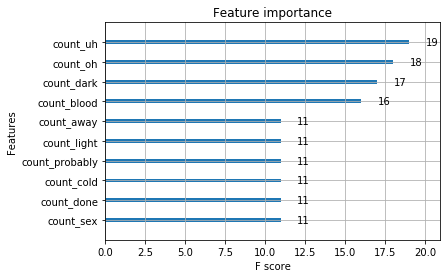

In [40]:

plot_importance(xg.best_estimator_,max_num_features=10)
plt.show()

Definitely still overfit, but much better performance on the test set!  The feature importances is also interesting - instead of a list of names, we have "uh" and "oh"?  "Dark" and "Blood" as well.  

In [50]:
genre_list = ['Adventure','Fantasy','Animation','Drama','Horror','Action','Comedy','History','Western','Thriller','Crime','Documentary','Science Fiction','Mystery','Music','Romance','Family','War','Foreign','TV Movie']

for g in genre_list:
    y = scripts['genre_list'].str.contains(g).astype('int')
    mn2 = scripts[y==1].count_uh.mean()
    print(g + ': ' +str(round(mn2*10000,1)) )
print('TOTAL:' +str(round(scripts.count_uh.mean()*10000,1)) )

Adventure: 7.3
Fantasy: 8.1
Animation: 18.7
Drama: 9.5
Horror: 4.1
Action: 5.9
Comedy: 16.5
History: 3.8
Western: 2.9
Thriller: 5.4
Crime: 9.7
Documentary: nan
Science Fiction: 5.2
Mystery: 7.3
Music: 8.4
Romance: 11.6
Family: 15.1
War: 4.2
Foreign: 0.0
TV Movie: nan
TOTAL:9.3


In [52]:
for g in genre_list:
    y = scripts['genre_list'].str.contains(g).astype('int')
    mn2 = scripts[y==1].count_blood.mean()
    print(g + ': ' +str(round(mn2*10000,1)) )
print('TOTAL:' +str(round(scripts.count_blood.mean()*10000,1)) )

Adventure: 9.4
Fantasy: 11.0
Animation: 1.7
Drama: 7.8
Horror: 22.1
Action: 12.9
Comedy: 4.1
History: 9.8
Western: 12.3
Thriller: 12.6
Crime: 10.5
Documentary: nan
Science Fiction: 11.4
Mystery: 12.4
Music: 7.3
Romance: 4.4
Family: 1.8
War: 12.1
Foreign: 47.8
TV Movie: nan
TOTAL:9.3


So comedies tend to have a lot of "uh"s in them, but not very much blood.  Let's try horror and see what happens!

In [58]:
genre = 'Horror'

X_train = train[X_list]
y_train = train['genre_list'].str.contains(genre).astype('int')

X_test = test[X_list]
y_test = test['genre_list'].str.contains(genre).astype('int')

clf = BernoulliNB()
clf.fit(X_train,y_train)
print ("Training Accuracy: " + str(round(100*clf.score(X_train,y_train),1)) + '%')
print("Test Accuracy: " + str(round(100*clf.score(X_test,y_test),1)) + '%')
print("Baseline Accuracy: " + str(round(100*(1-y_test.mean()),1)) + '%')

Training Accuracy: 85.2%
Test Accuracy: 75.9%
Baseline Accuracy: 87.0%


Accuracy is better, but the baseline for this one is much higher, since there are fewer horror movies. If you just picked 0 every time, you'd get 87% of them right!

Let's try the boosted tree again.

In [59]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = seed)
param_dist = {'n_estimators': stats.randint(5, 1000),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
xg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)
xg.fit(X_train, y_train)
xg.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.7min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8577995842125095, gamma=0,
              learning_rate=0.07591311781081342, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=None, n_estimators=944, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=4312,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.38167468739787536, verbosity=1)

In [60]:
print ("Training Accuracy: " + str(round(100*sum(y_train== xg.predict(X_train))/len(y_train),1)) + '%')
print("Test Accuracy: " + str(round(100*sum(y_test== xg.predict(X_test))/len(y_test),1)) + '%')

Training Accuracy: 99.4%
Test Accuracy: 88.9%


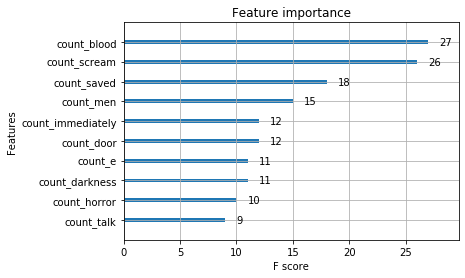

In [61]:
plot_importance(xg.best_estimator_,max_num_features=10)
plt.show()

There we go!  Blood, screem, horror, darkness. This all makes perfect sense.  Again we overfit by a pretty stagerring margin, but it's still a huge improvement over the Naive Bayes

# Conclusions
We were able to build an OK model for detecting genre based on the movie script. The Naive Bayes version was basically useless, but using a gradient-boosted tree, we were able to do pretty well. It was also nice to see some words that you'd expect (blood,scream) as well as some head-scratchers (uh, oh, probably).

We could loop through every genre, and build a suite of models to tell us the genre probability for each.  

I have no doubt we could build a better model if we had more data - 1000 movie scripts is a pretty small subset. I'm happy with the performance given that.

# VIDEO

Here is a video link:  https://youtu.be/BJubPygVUUk
